In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/Hotel System/'
df = pd.read_csv(path + 'hotel_train.csv')
df_test = pd.read_csv(path + 'hotel_test.csv')

print(f'Train shape: {df.shape}')
print(f'Test shape: {df_test.shape}')

Train shape: (65229, 25)
Test shape: (32412, 25)


In [3]:
print(df.head())

   id  is_canceled  ...  total_of_special_requests  total_nights
0   0            0  ...                          0             1
1   1            0  ...                          1             2
2   2            0  ...                          0             2
3   3            0  ...                          1             2
4   4            1  ...                          1             3

[5 rows x 25 columns]


Somebody has 10 babies with him/her. And somebody cancelled 26 reservations in the past.

In [4]:
df.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


Seems like perfect data for me

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

Lets clean guests with more than 5 babys. Otherwise it will be an Anomaly.

In [6]:
df[df['babies'] > 5]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
22995,30935,0,37.0,2016,January,3,12,0,2,2.0,0.0,10.0,BB,PRT,TA/TO,0,0,0,D,1,0,Transient,0,1,2
41528,59925,0,11.0,2015,October,42,11,2,1,1.0,0.0,9.0,BB,GBR,Corporate,0,0,0,A,1,0,Transient-Party,0,0,3


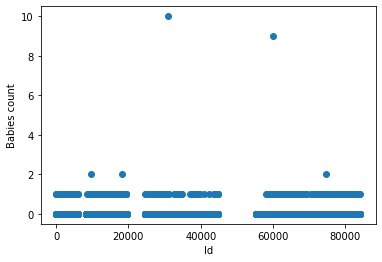

In [7]:
plt.scatter(df['id'], df['babies'])
plt.xlabel('Id')
plt.ylabel('Babies count')
plt.show()

In [8]:
df = df.loc[df['babies'] < 3, :]

Let's observe count of previous cancellations

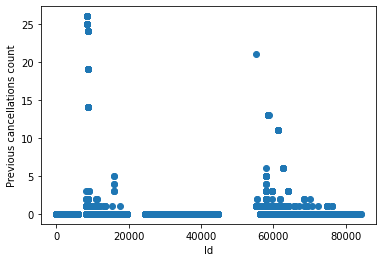

In [9]:
plt.scatter(df['id'], df['previous_cancellations'])
plt.xlabel('Id')
plt.ylabel('Previous cancellations count')
plt.show()

Label encoding

There was an error during test preprocessing (encoder met unseen categories, therefore I found this solution helpful:

https://stackoverflow.com/a/65538195/14715428

In [10]:
from sklearn.preprocessing import OrdinalEncoder


enc_cols = ['arrival_date_month',
            'reserved_room_type',
            'meal',
            'country',
            'distribution_channel',
            'customer_type']

for col in enc_cols:
    # Create encoder
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                             unknown_value=-1)
    # reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
    X = encoder.fit_transform(df[col].values.reshape(-1,1))
    X_test = encoder.transform(df_test[col].values.reshape(-1,1))

    # add this back into the original dataframe 
    encoded = pd.DataFrame(X, columns=[col + "_enc"])
    df = pd.concat([df, encoded], axis=1)

    encoded = pd.DataFrame(X_test, columns=[col + "_enc"])
    df_test = pd.concat([df_test, encoded], axis=1)

    df = df.drop([col], axis=1)
    df_test = df_test.drop([col], axis=1)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65227 non-null  float64
 1   is_canceled                     65227 non-null  float64
 2   lead_time                       65227 non-null  float64
 3   arrival_date_year               65227 non-null  float64
 4   arrival_date_week_number        65227 non-null  float64
 5   arrival_date_day_of_month       65227 non-null  float64
 6   stays_in_weekend_nights         65227 non-null  float64
 7   stays_in_week_nights            65227 non-null  float64
 8   adults                          65227 non-null  float64
 9   children                        65227 non-null  float64
 10  babies                          65227 non-null  float64
 11  is_repeated_guest               65227 non-null  float64
 12  previous_cancellations          

## Model

In [38]:
# X, y split

X = df.drop(['is_canceled'], axis=1)
y = df['is_canceled'].values.astype('bool')
X_test = df_test.drop(['is_canceled'], axis=1)
y_test = df_test['is_canceled'].values.astype('bool')

In [39]:
from sklearn.model_selection import train_test_split

# Validation split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3,
                                                      shuffle=True,
                                                      random_state=13)

# y_train, y_valid = y_train.values.astype('bool'), y_valid.values.astype('bool')

In [40]:
import xgboost as xgb

eval_set = [(X_train, y_train), (X_valid, y_valid)]
xgbr = xgb.XGBClassifier(eta=0.3,
                         max_depth=3,
                         objective='binary:logistic',
                         tree_method='gpu_hist',
                         random_state=13,
                         verbosity=2)

In [41]:
xgbr.fit(X_train, y_train,
         eval_metric=['aucpr', 'aucpr'], eval_set=eval_set,
         early_stopping_rounds=400, verbose=2)

[0]	validation_0-aucpr:0.861663	validation_1-aucpr:0.864173
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 400 rounds.
[2]	validation_0-aucpr:0.872588	validation_1-aucpr:0.875087
[4]	validation_0-aucpr:0.875736	validation_1-aucpr:0.879507
[6]	validation_0-aucpr:0.915439	validation_1-aucpr:0.918034
[8]	validation_0-aucpr:0.927214	validation_1-aucpr:0.92924
[10]	validation_0-aucpr:0.931918	validation_1-aucpr:0.934144
[12]	validation_0-aucpr:0.941134	validation_1-aucpr:0.944217
[14]	validation_0-aucpr:0.944992	validation_1-aucpr:0.947801
[16]	validation_0-aucpr:0.946469	validation_1-aucpr:0.949708
[18]	validation_0-aucpr:0.950115	validation_1-aucpr:0.953081
[20]	validation_0-aucpr:0.953822	validation_1-aucpr:0.956971
[22]	validation_0-aucpr:0.958542	validation_1-aucpr:0.960974
[24]	validation_0-aucpr:0.963414	validation_1-aucpr:0.96489
[26]	validation_0-aucpr:0.964061	validation_1-aucpr:

XGBClassifier(eta=0.3, random_state=13, tree_method='gpu_hist', verbosity=2)

In [45]:
from sklearn.metrics import roc_curve, auc, accuracy_score

# calculate the fpr and tpr for all thresholds of the binary classification
probs = xgbr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

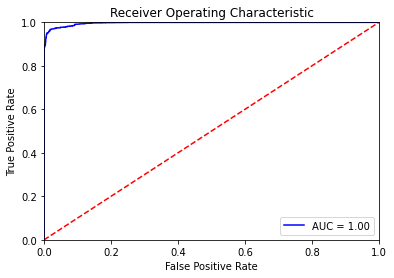

In [46]:
# plot

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
y_pred = xgbr.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(score)

0.975410341848698
